In [53]:
from lib import itselfmiti1
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile,ClassicalRegister
from qiskit.quantum_info import Operator
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator, Aer
from qiskit.utils.mitigation.fitters import CompleteMeasFitter,TensoredFilter,TensoredMeasFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal
import copy

In [54]:

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibm_oslo'))
backend_real_jakarta = provider.get_backend('ibm_oslo')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_real_jakarta

ibmqfactory.load_account:WARNING:2022-10-26 16:04:14,815: Credentials are already in use. The existing account in the session will be replaced.


In [55]:
dt=0.08
shots=20000
g=2
N_points=11
qubits=[1,3]
qubits_measure=[1,3]

In [56]:
t=dt
Trot_gate_qr=QuantumRegister(2)
Trot_gate=QuantumCircuit(Trot_gate_qr)

Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.ry(-0.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-0.375*t,Trot_gate_qr[0])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.ry(-1.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-2.25*t,Trot_gate_qr[0])
Trot_gate.rz(-1.125*t,Trot_gate_qr[1])
Trot_gate.ry(-3*g*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[0],Trot_gate_qr[1])
Trot_gate.ry(-g*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[0],Trot_gate_qr[1])
Trot_gate.ry(-1.5*g*t,Trot_gate_qr[0])
Trot_gate.rz(-1.125*t,Trot_gate_qr[1])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])
Trot_gate.rz(-0.375*t,Trot_gate_qr[0])
Trot_gate.ry(-0.5*g*t,Trot_gate_qr[0])
Trot_gate.cx(Trot_gate_qr[1],Trot_gate_qr[0])

Trot_gate.draw()


┌───┐┌───────────┐┌───────────┐┌───┐┌───────────┐┌───────────┐     »
q8336_0: ┤ X ├┤ Ry(-0.08) ├┤ Rz(-0.03) ├┤ X ├┤ Ry(-0.24) ├┤ Rz(-0.18) ├──■──»
         └─┬─┘└───────────┘└───────────┘└─┬─┘├───────────┤├───────────┤┌─┴─┐»
q8336_1: ──■──────────────────────────────■──┤ Rz(-0.09) ├┤ Ry(-0.48) ├┤ X ├»
                                             └───────────┘└───────────┘└───┘»
«                           ┌───────────┐┌───┐┌───────────┐┌───────────┐┌───┐
«q8336_0: ───────────────■──┤ Ry(-0.24) ├┤ X ├┤ Rz(-0.03) ├┤ Ry(-0.08) ├┤ X ├
«         ┌───────────┐┌─┴─┐├───────────┤└─┬─┘└───────────┘└───────────┘└─┬─┘
«q8336_1: ┤ Ry(-0.16) ├┤ X ├┤ Rz(-0.09) ├──■──────────────────────────────■──
«         └───────────┘└───┘└───────────┘

In [57]:
def final_circ(trotter_steps,qc=Trot_gate):
    qr=QuantumRegister(2,name="q")
    qc_aux=QuantumCircuit(qr)
    for i in range (0,trotter_steps):
        qc_aux.append(qc,qr)
    return qc_aux


In [58]:
backend=BACKEND
config=backend.configuration()
N_qubits_backend=config.n_qubits
qr = QuantumRegister(N_qubits_backend)
mit_pattern = [qubits_measure]
meas_calibs, state_labels = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')
print(len(meas_calibs))
job_cal = execute(meas_calibs, backend=BACKEND, shots=shots)
cal_results = job_cal.result()
cal_counts=cal_results.get_counts()
print(cal_counts)
meas_fitter = TensoredMeasFitter(cal_results, mit_pattern=mit_pattern)


4
[{'00': 18847, '01': 551, '10': 580, '11': 22}, {'00': 287, '01': 19210, '10': 16, '11': 487}, {'00': 308, '01': 17, '10': 19133, '11': 542}, {'00': 7, '01': 342, '10': 324, '11': 19327}]


In [59]:
def circs_run(N_trot,circs,meas_fitt=meas_fitter,backend=BACKEND,qubits=qubits,qubits_measure=qubits_measure):
    config=backend.configuration()
    N_qubits_backend=config.n_qubits
    N_qubits=len(qubits)
    N_qubits_measure=len(qubits_measure)

    qr=QuantumRegister(N_qubits_backend,name="q")
    qc=QuantumCircuit(qr)

    qr_target=[]
    for qubit in qubits:
        qr_target.append(qr[qubit])

    qc.append(final_circ(N_trot),qr_target)
    qc=transpile(qc,backend=BACKEND,optimization_level=0)


    

    cal_circs_GEM, s_labels = itselfmiti1.GEM_calibration_circuits(BACKEND,qc,qubits_measure=qubits_measure)
    circs += cal_circs_GEM[0]
    circs += cal_circs_GEM[1]
    

    
    #print(p)
    qr_aux=QuantumRegister(N_qubits_backend)
    cr=ClassicalRegister(len(qubits_measure))
    qc_aux=QuantumCircuit(qr_aux,cr)
    qc_aux.x(qr_aux[qubits[0]])
    qc_aux.append(qc,qr_aux)
    for i in range (0,len(qubits_measure)):
        qc_aux.measure([qr_aux[qubits_measure[i]]],[cr[i]])

    circs.append(qc_aux)

    return circs,s_labels

99
p_t
0.0653701845865159
rand_vec
[0.25562807 0.24926563 0.24782419 0.24728211]


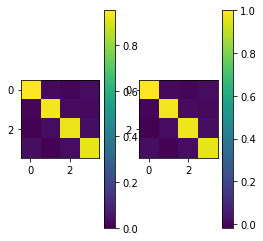

{'00': 2467.3600317346127, '01': 17023.140664827635, '10': 150.3638051913787, '11': 359.13549824637755}
{'00': 2640.277327652399, '01': 16236.225628119615, '10': 464.5407608298372, '11': 658.9562833981519}
{'00': 2486.3961310534723, '01': 17513.603868947324, '11': 1.1677772960328173e-10}
{'00': 2487.379107164145, '01': 17512.620892835723, '10': 1.6432246427271202e-10}
8.2161232136356e-15
0
0.02322703804149186
3
p_t
0.19820331225588936
rand_vec
[0.2573994  0.24983205 0.24427067 0.24849787]


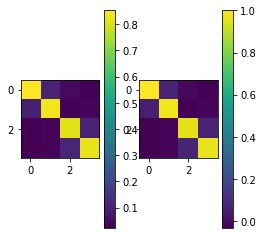

{'00': 8955.662640128192, '01': 9425.116682501268, '10': 845.6941679986278, '11': 773.526509371912}
{'00': 8200.968931148023, '01': 8547.378149675087, '10': 1646.3798897329843, '11': 1605.2730294439027}
{'00': 9009.591176445323, '01': 10161.547091794977, '10': 552.3379980655141, '11': 276.5237336941807}
{'00': 9007.648654644088, '01': 10133.182241338425, '10': 579.8596356016528, '11': 279.309468415835}
0.028992981780082642
0.027616899903275705
0.08231899448664921
3
p_t
0.3559141611914238
rand_vec
[0.24875827 0.25168567 0.24557756 0.2539785 ]


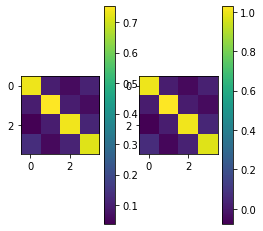

{'00': 11262.779232858973, '01': 2763.022438042757, '10': 5356.170047755492, '11': 618.0282813427773}
{'00': 9024.928463974502, '01': 3571.193513790719, '10': 5197.923886478191, '11': 2205.9541357565863}
{'00': 11356.03059695069, '01': 3608.8208181501113, '10': 4995.396114164638, '11': 39.75247073455835}
{'00': 11351.653258506807, '01': 3540.2945481967395, '10': 5062.1092636425465, '11': 45.942929653907186}
0.25310546318212734
0.2497698057082319
0.25989619432390954
3
p_t
0.45768324466029275
rand_vec
[0.26179193 0.23917614 0.25302855 0.24600337]


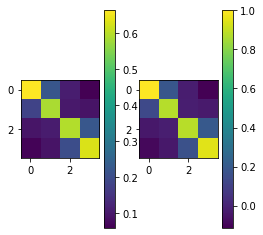

{'00': 6082.0153341797195, '01': 1564.1929651660955, '10': 12567.502979708326, '11': -213.71127905413914}
{'00': 5694.734437959304, '01': 3037.6263166180993, '10': 9131.706017234996, '11': 2135.933228187601}
{'00': 3561.6915775136185, '01': 1936.7590346396373, '10': 14105.547709352362, '11': 396.00167849438236}
{'00': 3612.306945713947, '01': 2211.037646488946, '10': 13835.307162536765, '11': 341.3482452603461}
0.6917653581268383
0.7052773854676181
0.4565853008617498
3
p_t
0.5217534831187361
rand_vec
[0.2585846  0.24530998 0.23858154 0.25752387]


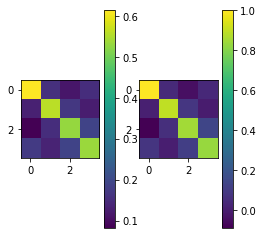

{'00': 791.8159603524834, '01': 663.1793522805248, '10': 18562.29193859178, '11': -17.28725122477736}
{'00': 3077.031537339828, '01': 2876.9899681507013, '10': 11366.966492180787, '11': 2679.0120023286863}
{'10': 20000.000000000004}
{'10': 20000.00000000001}
1.0000000000000004
1.0000000000000002
0.5683483246090394
3
p_t
0.5968481499166908
rand_vec
[0.24465536 0.26311804 0.24998041 0.24224619]


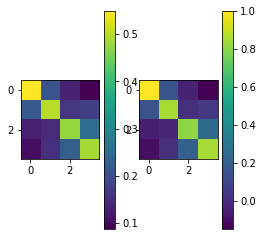

{'00': -370.4190215610912, '01': -1121.4640613344586, '10': 19024.414676225697, '11': 2467.468406669851}
{'00': 2771.1068215581968, '01': 2688.7100320301056, '10': 10653.734865101185, '11': 3886.448281310512}
{'00': 1.2856657084855754e-10, '01': 4.6645860980941956e-11, '10': 19045.328674103686, '11': 954.6713268546148}
{'01': 5.501488749229018e-12, '10': 19322.658734498138, '11': 677.3412854759256}
0.9661329367249069
0.9522664337051843
0.5326867432550593
3
p_t
0.703804540915749
rand_vec
[0.24468187 0.25884462 0.2443084  0.25216511]


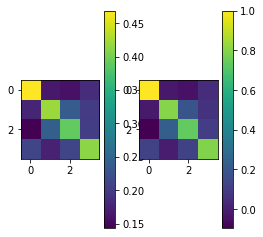

{'00': 2173.1413552440067, '01': -3601.2425582765227, '10': 15513.289225606106, '11': 5914.811977426409}
{'00': 4087.8388500084834, '01': 2576.8486511103893, '10': 8033.873095154741, '11': 5301.4394037263855}
{'00': 1705.9048058964297, '01': 1.0389581539868406e-08, '10': 13627.273268546202, '11': 4666.821925547}
{'00': 1661.7648254295393, '01': 5.474940434120313e-13, '10': 13985.452378801076, '11': 4352.782885920978}
0.6992726189400538
0.68136366342731
0.40169365475773705
3
p_t
0.753430655457792
rand_vec
[0.25304658 0.2534689  0.2265471  0.26693741]


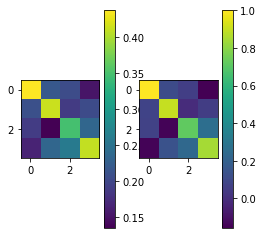

{'00': 4515.578326598009, '01': -1223.7656682709292, '10': 9135.962777816349, '11': 7572.224563856564}
{'00': 4926.464232097241, '01': 3517.681748421402, '10': 5666.398955262754, '11': 5889.455064218602}
{'00': 4578.643832289232, '01': 5.663942212830528e-09, '10': 7544.085054586709, '11': 7877.271113118393}
{'00': 3775.8010960573174, '01': 3.8708194213369346e-14, '10': 9566.619767642735, '11': 6657.579136303536}
0.4783309883821367
0.37720425272933544
0.2833199477631377
3
p_t
0.7873104800587946
rand_vec
[0.23697102 0.26032247 0.23521056 0.26749595]


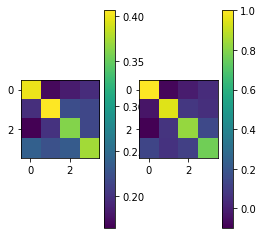

{'00': 4598.985537892982, '01': 3907.387610808321, '10': 4215.539014926378, '11': 7278.087836372316}
{'00': 4709.551321905873, '01': 4930.152569976293, '10': 4600.275777155347, '11': 5760.020330962487}
{'00': 4514.139547564478, '01': 6017.812746708234, '10': 1738.174624673927, '11': 7729.873081053362}
{'00': 4634.37334214436, '01': 3582.5355613688625, '10': 3899.1593472317045, '11': 7883.931749255068}
0.19495796736158522
0.08690873123369634
0.23001378885776735
3
p_t
0.8655418499957901
rand_vec
[0.22589235 0.26047884 0.25503202 0.25859679]


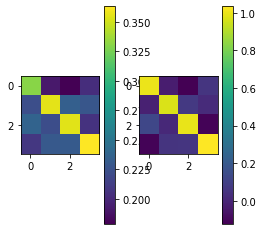

{'00': 3973.4392801223794, '01': 12256.473253413826, '10': -1768.519778418717, '11': 5538.607244882533}
{'00': 4444.6469672686635, '01': 6157.089389686583, '10': 4177.02580211876, '11': 5221.237840925995}
{'00': 4256.327720886912, '01': 11655.359196448237, '10': 4.955638263254445e-14, '11': 4088.3130828626645}
{'00': 4391.1412506384995, '01': 11247.87818065472, '10': 2.2658459203022587e-05, '11': 4360.980546048341}
1.1329229601511294e-09
2.4778191316272225e-18
0.208851290105938
3
p_t
0.849828533785044
rand_vec
[0.24884502 0.25145606 0.22838084 0.27131809]


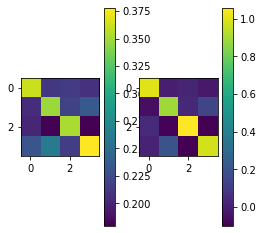

{'00': -1941.4176522407624, '01': 20414.304477645885, '10': 2203.1801070736365, '11': -676.0669324787677}
{'00': 3937.9663690290863, '01': 7339.536674185484, '10': 4212.545799410715, '11': 4509.951157374715}
{'01': 20000.0, '10': 4.624330390544983e-09, '11': 1.2830141967827454e-08}
{'01': 18700.820722399152, '10': 992.4489127524084, '11': 306.73036920265594}
0.04962244563762042
2.3121651952724913e-13
0.21062728997053573
3


In [60]:
circs=[]
P_GEM=[]
P_GEM_plus=[]
P_CGP=[]
P_raw=[]
P_t=[]
b_0=[]
b_1=[]

#preparation of circuits
for i in range (1,N_points+1):
    circs,s_labels=circs_run(i,circs)

#execution
print(len(circs))
job=execute(circs,BACKEND,shots=shots,optimization_level=0)
job_result=job.result()
job_counts=job_result.get_counts()


for i in range(0,N_points):
    #define the GEM calibration jobs with meas mitigation
    job_GEM_L=copy.deepcopy(cal_results)
    job_GEM_R=copy.deepcopy(cal_results)
    for j in range (0,len(s_labels)):
        job_GEM_L.results[j].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+1)+j],method="least_squares")
        job_GEM_R.results[j].data.counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+1)+j+len(s_labels)],method="least_squares")

    #raw circuit with meas miti
    raw_counts=meas_fitter.filter.apply(job_counts[i*(2*len(s_labels)+1)+2*len(s_labels)],method="least_squares")

    

    
    meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L, state_labels=s_labels)
    meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R, state_labels=s_labels)
    Cal_GEM_L = meas_fitter_GEM_L.cal_matrix
    Cal_GEM_R = meas_fitter_GEM_R.cal_matrix
    C=(Cal_GEM_L+Cal_GEM_R)/2
    C_GEM=[]
    C_GEM.append(C)
    C_GEM_plus=[]
    CGP=[]
    
    #define the equilibrium counts distribution
    rand_vec_prob=np.sum(C,axis=1,dtype='float')/len(s_labels)
    
    
    #calculate the probaabilities of dep error
    p_t=(C[0][0]-1)/(rand_vec_prob[0]-1)

    print('p_t')
    print(p_t)
    print('rand_vec')
    print(rand_vec_prob)
    rand_vec=p_t*shots*rand_vec_prob

    D=np.zeros((len(s_labels),len(s_labels)))

    for i in range (0,len(s_labels)):
        for j in range (0,len(s_labels)):
            D[i][j]=(C[i][j]-p_t*rand_vec_prob[i])/(1-p_t)
    CGP.append(D)
    
    


    meas_fitter_GP=copy.deepcopy(meas_fitter)
    meas_fitter_GP.cal_matrices=CGP

    meas_fitter_GEM=copy.deepcopy(meas_fitter)
    meas_fitter_GEM.cal_matrices=C_GEM


    plt.subplot(132)
    plt.imshow(C)
    plt.colorbar()
    plt.subplot(133)
    plt.imshow(D)
    plt.colorbar()
    plt.show()
    #define the new counts
    raw_vector=itselfmiti1.occurrences_to_vector(raw_counts)
    new_vector_CGP=(raw_vector-rand_vec)/(1-p_t)
    new_counts=dict(zip(s_labels,new_vector_CGP))
    print(new_counts)
    print(raw_counts)

    
    new_counts_GEM=meas_fitter_GEM.filter.apply(raw_counts,method="least_squares")
    new_counts_CGP=meas_fitter_GP.filter.apply(new_counts,method="least_squares")
    print(new_counts_GEM)
    print(new_counts_CGP)
    for output in ['10']:
        if output in new_counts_GEM:
            p_GEM = new_counts_GEM[output]/shots
        else:
            p_GEM= 0
    
    for output in ['10']:
        if output in raw_counts:
            p_raw = raw_counts[output]/shots
        else:
            p_raw = 0
    for output in ['10']:
        if output in new_counts_CGP:
            p_CGP = new_counts_CGP[output]/shots
        else:
            p_CGP = 0
    
    P_GEM.append(p_GEM)
    P_CGP.append(p_CGP)
    P_raw.append(p_raw)
    P_t.append(p_t)
    b_0.append(rand_vec_prob[0])
    b_1.append(rand_vec_prob[1])

    print(p_CGP)
    print(p_GEM)
    print(p_raw)
    print(i)
    


In [61]:
def simulation_ideal(N_trot,qubits=qubits,qubits_measure=qubits_measure,shots=100000):

    qr_aux=QuantumRegister(7)
    cr=ClassicalRegister(len(qubits_measure))
    qc_aux=QuantumCircuit(qr_aux,cr)
    qc_aux.x(qr_aux[qubits[0]])
    qc_aux.append(final_circ(N_trot),[qr_aux[qubits[0]],qr_aux[qubits[1]]])
    for i in range (0,len(qubits_measure)):
        qc_aux.measure(qr_aux[qubits_measure[i]],cr[i])

    job_ideal = execute (qc_aux,backend=backend_sim_ideal,shots=shots,optimization_level=0)
    ideal_result=job_ideal.result()
    ideal=ideal_result.get_counts()
    for output in ['10']:
        if output in ideal:
            p_ideal = ideal[output]/shots
        else:
            p_ideal = 0
    

    return p_ideal

In [62]:
P_ideal=[]
for i in range (1,N_points+1):
    a=simulation_ideal(i)
    P_ideal.append(a)

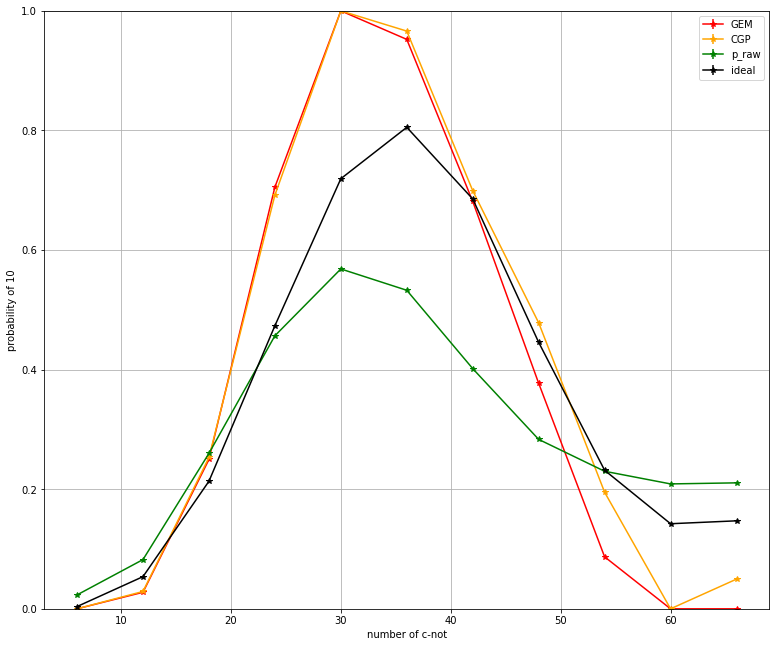

In [63]:

n=np.arange(1,len(P_GEM)+1,1)
n=n*6
db=0.000000001



plt.figure(figsize=(13,11))
plt.errorbar(n,P_GEM, db, linestyle='-', marker='*', color= 'red',label='GEM')
plt.errorbar(n,P_CGP, db, linestyle='-', marker='*', color= 'orange',label='CGP')
plt.errorbar(n,P_raw, db, linestyle='-', marker='*', color= 'green',label='p_raw')
plt.errorbar(n,P_ideal, db, linestyle='-', marker='*', color= 'black',label='ideal')



plt.xlabel('number of c-not')
plt.ylabel(r'probability of 10')
plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()

[ 1  2  3  4  5  6  7  8  9 10 11]
11


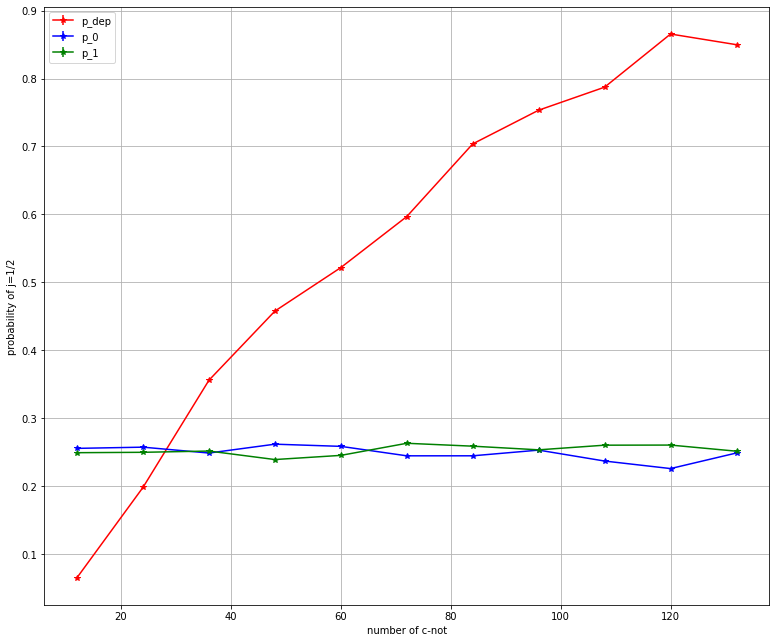

In [64]:

n=np.arange(1,len(P_GEM)+1,1)
print(n)
print(len(n))
n=n*12
db=0.000000001

plt.figure(figsize=(13,11))
plt.errorbar(n,P_t, db, linestyle='-', marker='*', color= 'red',label='p_dep')
plt.errorbar(n,b_0, db, linestyle='-', marker='*', color= 'blue',label='p_0')
plt.errorbar(n,b_1, db, linestyle='-', marker='*', color= 'green',label='p_1')

plt.xlabel('number of c-not')
plt.ylabel(r'probability of j=1/2')
#plt.ylim(0,1)
plt.legend()
plt.grid()
plt.show()